# **Data Modeling**

## **Importing the Packages**

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# Configure display options
pd.set_option('display.max_columns', None)

# Scikit-learn modules for model building and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Scikit-learn metrics
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error, mean_absolute_error

**Loading the Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv('/content/drive/MyDrive/BPA/Final_Dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1778336 entries, 0 to 1778335
Columns: 110 entries, Crash ID to Texas Triangle
dtypes: bool(72), float64(12), int64(26)
memory usage: 637.7 MB


## Research Question - 01:

### 🎯 Dependent Variable (Target)

| Variable         | Description                                      |
|------------------|--------------------------------------------------|
| `Crash Severity` | Encoded ordinal target (e.g., Not Injured to Fatal) |

---

## 🧠 Independent Variables (Features)

### 🔢 Numerical Features (Scaled using MinMax)

- `Crash Hour`: Hour of the day (0–23)
- `Person Age`: Age of the person involved in the crash
- `Vehicle Age`: Age of the vehicle involved
- `Speed Limit`: Posted speed limit at crash location
- `Nearest Trauma Center Distance`: Distance (in miles) to nearest trauma center
- `Day of Week Sin`, `Day of Week Cos`: Cyclical encoding of day of the week
- `Month Sin`, `Month Cos`: Cyclical encoding of month
- `Vehicle Direction of Force Sin`, `Cos`: Trig features for directional analysis

---

### 🌦️ Environmental and Road Condition Features

- `Road Class_*`: CITY STREET, INTERSTATE, TOLLWAY, OTHER ROADS, etc.
- `Weather Condition_*`: Clear, Rain, Cloudy, Adverse Weather, Other
- `Roadway Type_*`: 2 LANE 2 WAY, DIVIDED, UNDIVIDED, OTHER
- `Construction Zone Flag`
- `At Intersection Flag`
- `Rural Urban Type`
- `Texas Triangle`: Indicates crash inside major metro area (Dallas-Houston-Austin)

---

### 🧍 Driver-Related Features

- `Driver Alcohol Result`
- `Driver Drug Test Result`
- `Driver License Class`, `Driver License Type`
- `Driver License Type Complexity`
- `Youth Driver`, `Elderly Driver`
- `Repeat Offender`
- `Driver Impairment`

---

### 🚘 Vehicle-Related Features

- `Vehicle Damage Rating 1 - Severity`
- `Vehicle Hit and Run Flag`
- `Vehicle Damage Area_*`: Front, Side, Rear, Angular, Rollover, etc.

---

### ⏱️ Temporal Features

- `Is Rush Hour`
- `Time_*`: Morning, Afternoon, Evening, Night
- `Season_*`: Spring, Summer, Fall, Winter
- `Light_*`: Daylight, Dark, Twilight

---

### ⚠️ Crash Event Features

- `Contributing Factor_*`: Speed-related, Lane Violation, Driver Behavior, etc.
- `Event_*`: Collision, Overturned, Fixed Object, Pedestrian, etc.
- `Manner of Collision_*`: Angle, Opposite Direction, One Motor Vehicle, etc.
- `Roadway Relation_*`: On Roadway, Off Roadway, Shoulder, etc.


In [4]:
# Re-group into 3 categories
df['Crash Severity'] = df['Crash Severity'].map({
    0: 0,  # Not Injured / Unknown → Minor or No Injury
    1: 0,  # Possible Injury → Minor or No Injury
    2: 1,  # Suspected Minor Injury → Moderate Injury
    3: 2,  # Suspected Serious Injury → Severe Injury
    4: 2   # Fatal Injury → Severe Injury
})

# Check distribution
print(df['Crash Severity'].value_counts())

Crash Severity
0    1486025
1     237890
2      54421
Name: count, dtype: int64


In [5]:
# Check distribution
print(df['Crash Severity'].value_counts())

Crash Severity
0    1486025
1     237890
2      54421
Name: count, dtype: int64


In [6]:
# Drop target and unrelated columns for RQ1
drop_cols = ['Crash ID', 'Crash Severity', 'Fatal Crash Flag', 'Clearance Duration',
             'Response Time', 'Unit Total Injury Count', 'Unit Suspected Serious Injury Count',
             'Person Death Count']  # Optional: remove injury outcome leakage

# Full feature and target set
X_full = df.drop(columns=drop_cols)
y_full = df['Crash Severity']

# Split training and validation
X1 = X_full.iloc[:-50000].copy()
y1 = y_full.iloc[:-50000].copy()
X1_val = X_full.iloc[-50000:].copy()
y1_val = y_full.iloc[-50000:].copy()

print(X1.info())
print(y1.info())
print(X1_val.info())
print(y1_val.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728336 entries, 0 to 1728335
Columns: 102 entries, Latitude to Texas Triangle
dtypes: bool(72), float64(10), int64(20)
memory usage: 514.3 MB
None
<class 'pandas.core.series.Series'>
RangeIndex: 1728336 entries, 0 to 1728335
Series name: Crash Severity
Non-Null Count    Dtype
--------------    -----
1728336 non-null  int64
dtypes: int64(1)
memory usage: 13.2 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 1728336 to 1778335
Columns: 102 entries, Latitude to Texas Triangle
dtypes: bool(72), float64(10), int64(20)
memory usage: 14.9 MB
None
<class 'pandas.core.series.Series'>
RangeIndex: 50000 entries, 1728336 to 1778335
Series name: Crash Severity
Non-Null Count  Dtype
--------------  -----
50000 non-null  int64
dtypes: int64(1)
memory usage: 390.8 KB
None


**Scaling**

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Convert boolean columns to int
bool_cols = X1.select_dtypes(include=['bool']).columns
X1[bool_cols] = X1[bool_cols].astype(int)
X1_val[bool_cols] = X1_val[bool_cols].astype(int)

# Identify numeric columns
num_cols = X1.select_dtypes(include=['int64', 'float64']).columns

# Fit scaler on training data, apply to both training and validation
scaler = MinMaxScaler()
X1[num_cols] = scaler.fit_transform(X1[num_cols])
X1_val[num_cols] = scaler.transform(X1_val[num_cols])

# Train/test split for internal testing
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    cohen_kappa_score, roc_auc_score, confusion_matrix
)
# Initialize and train
lr = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=42)
lr.fit(X_train, y_train)

# Train predictions
y_train_pred_lr = lr.predict(X_train)
y_train_proba_lr = lr.predict_proba(X_train)

# Test predictions
y_test_pred_lr = lr.predict(X_test)
y_test_proba_lr = lr.predict_proba(X_test)

# Define a reusable evaluation function
def evaluate_classification(y_true, y_pred, y_proba, dataset_name="Test"):
    print(f"--- {dataset_name} Metrics ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_true, y_pred, average='macro'))
    print("Cohen’s Kappa:", cohen_kappa_score(y_true, y_pred))
    print("AUC (OvR, weighted):", roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted'))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print()

# print both
print("Logistic Regression")
evaluate_classification(y_train, y_train_pred_lr, y_train_proba_lr, dataset_name="Training")
evaluate_classification(y_test, y_test_pred_lr, y_test_proba_lr, dataset_name="Testing")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression
--- Training Metrics ---
Accuracy: 0.8357610748573152
Precision (macro): 0.5702929229022987
Recall (macro): 0.36063193739427474
F1 Score: 0.3558557775539997
Cohen’s Kappa: 0.05029904322206957
AUC (OvR, weighted): 0.72653210207138
Confusion Matrix:
 [[1005402    4073    1282]
 [ 157330    3221    1222]
 [  33377    1418    2510]]

--- Testing Metrics ---
Accuracy: 0.8356666621665146
Precision (macro): 0.5635338971724899
Recall (macro): 0.3590532579137742
F1 Score: 0.35317561792368046
Cohen’s Kappa: 0.04874713750192938
AUC (OvR, weighted): 0.7262360070309066
Confusion Matrix:
 [[430925   1707    572]
 [ 67546   1375    501]
 [ 14239    642    994]]



In [9]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Predict
y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)

In [10]:
print("Decision Tree")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision (macro):", precision_score(y_test, y_pred_dt, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_dt, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred_dt, average='macro'))
print("Cohen’s Kappa:", cohen_kappa_score(y_test, y_pred_dt))
print("AUC (OvR, weighted):", roc_auc_score(y_test, y_proba_dt, multi_class='ovr', average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Decision Tree
Accuracy: 0.8297669628409589
Precision (macro): 0.5965460344393066
Recall (macro): 0.6177972019006673
F1 Score: 0.6065750810999843
Cohen’s Kappa: 0.41985768044339133
AUC (OvR, weighted): 0.7238023642149725
Confusion Matrix:
 [[388059  37681   7464]
 [ 31711  34971   2740]
 [  6014   2656   7205]]


In [11]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)

In [12]:
print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision (macro):", precision_score(y_test, y_pred_rf, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred_rf, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred_rf, average='macro'))
print("Cohen’s Kappa:", cohen_kappa_score(y_test, y_pred_rf))
print("AUC (OvR, weighted):", roc_auc_score(y_test, y_proba_rf, multi_class='ovr', average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest
Accuracy: 0.8919404205584945
Precision (macro): 0.9055454561286232
Recall (macro): 0.5819688925713629
F1 Score: 0.667069333847861
Cohen’s Kappa: 0.48741402515446974
AUC (OvR, weighted): 0.9002470854295197
Confusion Matrix:
 [[431803   1086    315]
 [ 44648  24343    431]
 [  8870    679   6326]]


**Tuning the Model**

**Logistic Regression**

In [13]:
"""from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    cohen_kappa_score, roc_auc_score, confusion_matrix
)
from scipy.stats import uniform

# Define parameter distribution
param_dist = {
    'C': uniform(loc=0.01, scale=10),  # Range from 0.01 to ~10
    'solver': ['lbfgs'],               # Multinomial support
    'multi_class': ['multinomial'],
    'max_iter': [1000]
}

# Setup RandomizedSearchCV
random_lr = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=2,
    random_state=42
)

# Fit model
random_lr.fit(X_train, y_train)"""

"from sklearn.linear_model import LogisticRegression\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.metrics import (\n    accuracy_score, precision_score, recall_score, f1_score,\n    cohen_kappa_score, roc_auc_score, confusion_matrix\n)\nfrom scipy.stats import uniform\n\n# Define parameter distribution\nparam_dist = {\n    'C': uniform(loc=0.01, scale=10),  # Range from 0.01 to ~10\n    'solver': ['lbfgs'],               # Multinomial support\n    'multi_class': ['multinomial'],\n    'max_iter': [1000]\n}\n\n# Setup RandomizedSearchCV\nrandom_lr = RandomizedSearchCV(\n    estimator=LogisticRegression(random_state=42),\n    param_distributions=param_dist,\n    n_iter=20,\n    scoring='accuracy',\n    cv=5,\n    verbose=1,\n    n_jobs=2,\n    random_state=42\n)\n\n# Fit model\nrandom_lr.fit(X_train, y_train)"

In [14]:
# Define and fit the best model using known best parameters
best_lr = LogisticRegression(
    C=0.5908361216819946,
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    random_state=42
)

best_lr.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=0.5908361216819946, max_iter=1000,
                   multi_class='multinomial', random_state=42)

In [15]:
# Predict on training data
y_train_pred_lr_tuned = best_lr.predict(X_train)
y_train_proba_lr_tuned = best_lr.predict_proba(X_train)

# Predict on testing data
y_test_pred_lr_tuned = best_lr.predict(X_test)
y_test_proba_lr_tuned = best_lr.predict_proba(X_test)

# Define the evaluation function
def evaluate_classification(y_true, y_pred, y_proba, dataset_name="Test"):
    print(f"--- {dataset_name} Metrics ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_true, y_pred, average='macro'))
    print("Cohen’s Kappa:", cohen_kappa_score(y_true, y_pred))
    print("AUC (OvR, weighted):", roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted'))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print()

# Now print both
print("Tuned Logistic Regression")
evaluate_classification(y_train, y_train_pred_lr_tuned, y_train_proba_lr_tuned, dataset_name="Training")
evaluate_classification(y_test, y_test_pred_lr_tuned, y_test_proba_lr_tuned, dataset_name="Testing")

Tuned Logistic Regression
--- Training Metrics ---
Accuracy: 0.8357230531436105
Precision (macro): 0.5690780308481483
Recall (macro): 0.36024845858428794
F1 Score: 0.3552334348004565
Cohen’s Kappa: 0.04996006829460764
AUC (OvR, weighted): 0.7265827803808597
Confusion Matrix:
 [[1005398    4093    1266]
 [ 157334    3222    1217]
 [  33405    1433    2467]]

--- Testing Metrics ---
Accuracy: 0.8356338753445027
Precision (macro): 0.5625912966742501
Recall (macro): 0.35882586912092895
F1 Score: 0.35278960215997923
Cohen’s Kappa: 0.04839401309047664
AUC (OvR, weighted): 0.7262527708387816
Confusion Matrix:
 [[430925   1700    579]
 [ 67565   1367    490]
 [ 14240    650    985]]



**Decision Tree Classification**

In [16]:
"""from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
dt = DecisionTreeClassifier(random_state=42)
param_dist = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

rand_dt = RandomizedSearchCV(estimator=dt, param_distributions=param_dist,
                             n_iter=30, cv=5, n_jobs=2, scoring='accuracy', random_state=42, verbose=1)

rand_dt.fit(X_train, y_train)
print("Best Parameters:", rand_dt.best_params_)

Best Parameters: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10, 'criterion': 'entropy'}


"""

'from sklearn.tree import DecisionTreeClassifier\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import randint\ndt = DecisionTreeClassifier(random_state=42)\nparam_dist = {\n    \'max_depth\': [5, 10, 15, 20, None],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'criterion\': [\'gini\', \'entropy\']\n}\n\nrand_dt = RandomizedSearchCV(estimator=dt, param_distributions=param_dist,\n                             n_iter=30, cv=5, n_jobs=2, scoring=\'accuracy\', random_state=42, verbose=1)\n\nrand_dt.fit(X_train, y_train)\nprint("Best Parameters:", rand_dt.best_params_)\n\nBest Parameters: {\'min_samples_split\': 10, \'min_samples_leaf\': 4, \'max_depth\': 10, \'criterion\': \'entropy\'}\n\n\n'

In [17]:
# Use best model

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

#best_dt = rand_dt.best_estimator_
best_dt = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)
best_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4,
                       min_samples_split=10, random_state=42)

In [18]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    cohen_kappa_score, roc_auc_score, confusion_matrix
)

# Predict on training data
y_train_pred_dt = best_dt.predict(X_train)
y_train_proba_dt = best_dt.predict_proba(X_train)

# Predict on test data
y_test_pred_dt = best_dt.predict(X_test)
y_test_proba_dt = best_dt.predict_proba(X_test)


# print both
print("Tuned Decision Tree")
evaluate_classification(y_train, y_train_pred_dt, y_train_proba_dt, dataset_name="Training")
evaluate_classification(y_test, y_test_pred_dt, y_test_proba_dt, dataset_name="Testing")

Tuned Decision Tree
--- Training Metrics ---
Accuracy: 0.8393103191757554
Precision (macro): 0.632490590601365
Recall (macro): 0.3839918878450102
F1 Score: 0.39535833841026896
Cohen’s Kappa: 0.09935464004844852
AUC (OvR, weighted): 0.7438110654762045
Confusion Matrix:
 [[1003881    5322    1554]
 [ 152975    7308    1490]
 [  30140    2927    4238]]

--- Testing Metrics ---
Accuracy: 0.8379250956121589
Precision (macro): 0.6032826219949555
Recall (macro): 0.37867391417472174
F1 Score: 0.3865343341642738
Cohen’s Kappa: 0.09017866208918246
AUC (OvR, weighted): 0.7381867044235295
Confusion Matrix:
 [[430012   2472    720]
 [ 65910   2822    690]
 [ 12952   1292   1631]]



**Random Forest Classification**

In [19]:
"""from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import numpy as np

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Define parameter distribution
param_dist_rf = {
    'n_estimators': [50, 100],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Randomized Search with 3-fold CV
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=5,
    cv=3,
    n_jobs=-1,
    scoring='accuracy',
    random_state=10,
    verbose=1
)

# Fit the model
random_search_rf.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters (RF):", random_search_rf.best_params_)
print("Best Cross-Validated Accuracy: {:.4f}".format(random_search_rf.best_score_))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters (RF): {'n_estimators': 50, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
Best Cross-Validated Accuracy: 0.8360
"""

'from sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import randint\nimport numpy as np\n\n# Initialize model\nrf = RandomForestClassifier(random_state=42)\n\n# Define parameter distribution\nparam_dist_rf = {\n    \'n_estimators\': [50, 100],\n    \'max_depth\': [2, 5, 10],\n    \'min_samples_split\': [2, 4, 6],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'max_features\': [\'sqrt\', \'log2\'],\n    \'bootstrap\': [True, False]\n}\n\n# Randomized Search with 3-fold CV\nrandom_search_rf = RandomizedSearchCV(\n    estimator=rf,\n    param_distributions=param_dist_rf,\n    n_iter=5,\n    cv=3,\n    n_jobs=-1,\n    scoring=\'accuracy\',\n    random_state=10,\n    verbose=1\n)\n\n# Fit the model\nrandom_search_rf.fit(X_train, y_train)\n\n# Print best parameters and best score\nprint("Best Parameters (RF):", random_search_rf.best_params_)\nprint("Best Cross-Validated Accuracy: {:.4f}".format(random_search_rf.best_score

In [20]:
# Define and fit the best model using known best parameters

from sklearn.ensemble import RandomForestClassifier

best_rf = RandomForestClassifier(
    n_estimators=50,
    min_samples_split=4,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=10,
    bootstrap=False,
    random_state=42
)

best_rf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_split=4,
                       n_estimators=50, random_state=42)

In [21]:
# Predict on training data
y_train_pred_rf = best_rf.predict(X_train)
y_train_proba_rf = best_rf.predict_proba(X_train)

# Predict on testing data
y_test_pred_rf = best_rf.predict(X_test)
y_test_proba_rf = best_rf.predict_proba(X_test)


# Now print both
print("Tuned Random Forest")
evaluate_classification(y_train, y_train_pred_rf, y_train_proba_rf, dataset_name="Training")
evaluate_classification(y_test, y_test_pred_rf, y_test_proba_rf, dataset_name="Testing")

Tuned Random Forest
--- Training Metrics ---
Accuracy: 0.8362280806886889
Precision (macro): 0.8691318459226417
Recall (macro): 0.34026893518508444
F1 Score: 0.31721261457950456
Cohen’s Kappa: 0.008909863829974274
AUC (OvR, weighted): 0.7519111897557145
Confusion Matrix:
 [[1010726      13      18]
 [ 161470     253      50]
 [  36557      29     719]]

--- Testing Metrics ---
Accuracy: 0.8358942412840091
Precision (macro): 0.6912455109546723
Recall (macro): 0.3378700003265412
F1 Score: 0.31254398070052963
Cohen’s Kappa: 0.005927162490918403
AUC (OvR, weighted): 0.7464499366069577
Confusion Matrix:
 [[433154     23     27]
 [ 69320     52     50]
 [ 15642     27    206]]



**XGBoost Classification**

In [22]:
from xgboost import XGBClassifier

# Initialize and train XGBoost model
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [23]:
# Predict on training data
y_train_pred_xgb = xgb.predict(X_train)
y_train_proba_xgb = xgb.predict_proba(X_train)

# Predict on testing data
y_test_pred_xgb = xgb.predict(X_test)
y_test_proba_xgb = xgb.predict_proba(X_test)


# Now print both
print("XGBoost Classifier")
evaluate_classification(y_train, y_train_pred_xgb, y_train_proba_xgb, dataset_name="Training")
evaluate_classification(y_test, y_test_pred_xgb, y_test_proba_xgb, dataset_name="Testing")

XGBoost Classifier
--- Training Metrics ---
Accuracy: 0.8444936706245066
Precision (macro): 0.6969225910353577
Recall (macro): 0.41298788579245055
F1 Score: 0.4399830340300183
Cohen’s Kappa: 0.14924216063325224
AUC (OvR, weighted): 0.7938046506589974
Confusion Matrix:
 [[1003495    5685    1577]
 [ 148270   11724    1779]
 [  28072    2754    6479]]

--- Testing Metrics ---
Accuracy: 0.8416936515069402
Precision (macro): 0.651675047699737
Recall (macro): 0.4019089935366617
F1 Score: 0.4226645273693282
Cohen’s Kappa: 0.13205452364702164
AUC (OvR, weighted): 0.7794514570029377
Confusion Matrix:
 [[429613   2819    772]
 [ 64123   4419    880]
 [ 12142   1346   2387]]



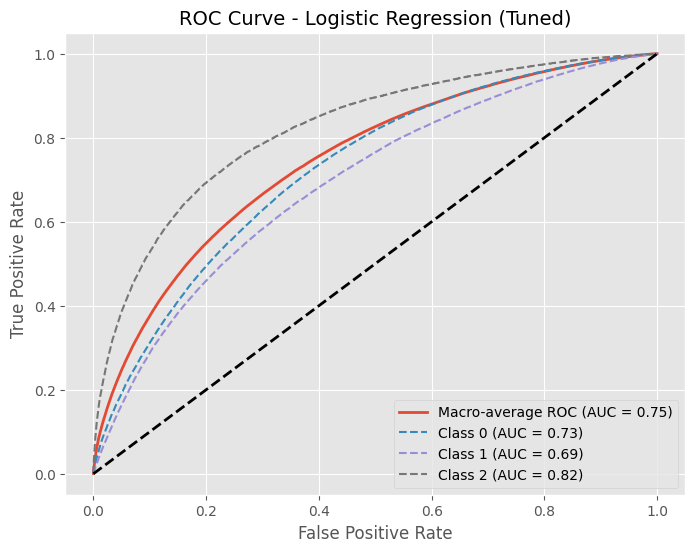

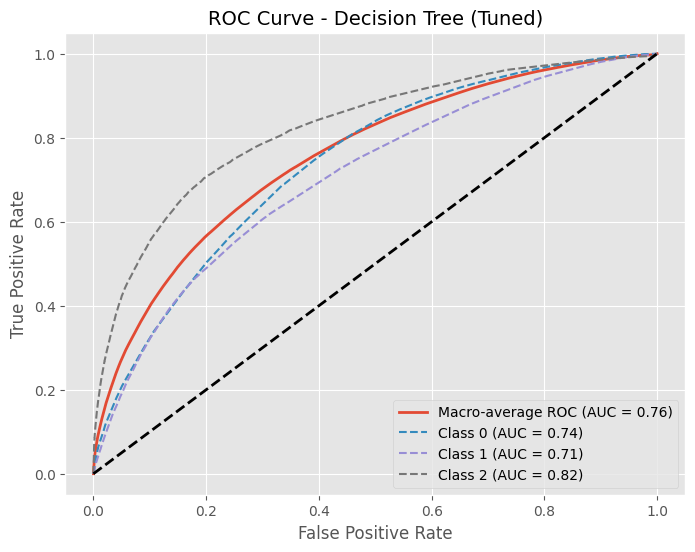

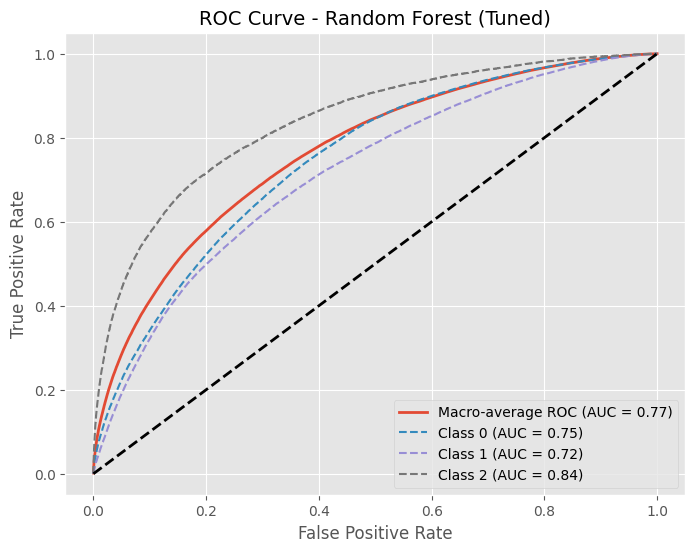

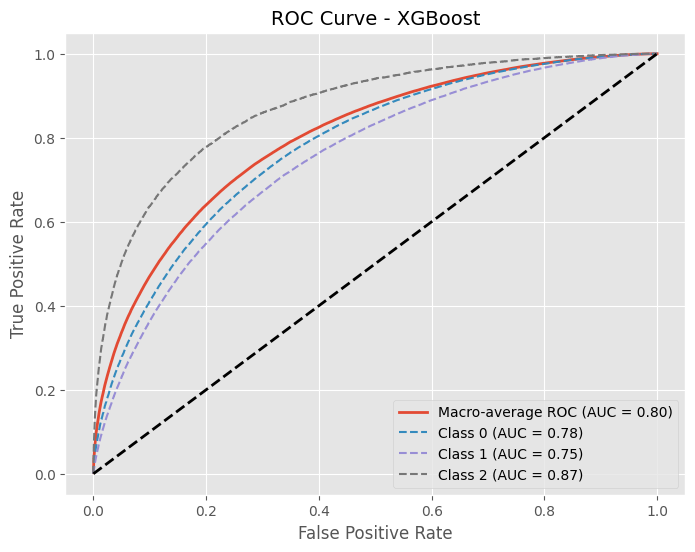

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize y_test for multi-class ROC
y1_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y1_test_bin.shape[1]

# Use TEST predicted probabilities
model_probs = {
    "Logistic Regression (Tuned)": y_test_proba_lr_tuned,
    "Decision Tree (Tuned)": y_test_proba_dt,
    "Random Forest (Tuned)": y_test_proba_rf,
    "XGBoost": y_test_proba_xgb
}

# Plot ROC curves for each model
for model_name, probs in model_probs.items():
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y1_test_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(all_fpr, mean_tpr, label=f"Macro-average ROC (AUC = {macro_auc:.2f})", linewidth=2)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], linestyle='--', label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.title(f"ROC Curve - {model_name}", fontsize=14)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

**Validating on best model**

XGBoost has performed best. Using it to predict on Validation dataset.

In [25]:
# Predict on validation set
y_val_pred_xgb = xgb.predict(X1_val)
y_val_proba_xgb = xgb.predict_proba(X1_val)

# Evaluate on validation set
evaluate_classification(y1_val, y_val_pred_xgb, y_val_proba_xgb, dataset_name="Validation")

--- Validation Metrics ---
Accuracy: 0.84366
Precision (macro): 0.5973216876847357
Recall (macro): 0.3763985438945689
F1 Score: 0.38393928608866273
Cohen’s Kappa: 0.09097362251053631
AUC (OvR, weighted): 0.7628617420776488
Confusion Matrix:
 [[41757   235    72]
 [ 6325   315    55]
 [ 1017   113   111]]



## Research Question - 02:

In [26]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Make a copy to avoid changing df used in RQ1
df_rq2 = df.copy()

# Drop columns with leakage or identifiers
drop_cols_rq2 = ['Crash ID', 'Clearance Duration', 'Response Time', 'Crash Severity',
                 'Fatal Crash Flag', 'Unit Total Injury Count', 'Person Death Count']

# Full features and target
X2_full = df_rq2.drop(columns=drop_cols_rq2).copy()
y2_full = df_rq2['Clearance Duration']

# Split validation set
X2 = X2_full.iloc[:-50000].copy()
y2 = y2_full.iloc[:-50000].copy()
X2_val = X2_full.iloc[-50000:].copy()
y2_val = y2_full.iloc[-50000:].copy()

# Handle boolean columns
bool_cols_rq2 = X2.select_dtypes(include='bool').columns
X2[bool_cols_rq2] = X2[bool_cols_rq2].astype(int)
X2_val[bool_cols_rq2] = X2_val[bool_cols_rq2].astype(int)

# Scale numeric columns
num_cols_rq2 = X2.select_dtypes(include=['int64', 'float64']).columns
X2[num_cols_rq2] = X2[num_cols_rq2].astype('float64')
X2_val[num_cols_rq2] = X2_val[num_cols_rq2].astype('float64')

# Fit scaler on training, apply to both train and val
scaler2 = MinMaxScaler()
X2[num_cols_rq2] = scaler2.fit_transform(X2[num_cols_rq2])
X2_val[num_cols_rq2] = scaler2.transform(X2_val[num_cols_rq2])

# Train/test split on training data
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

**Linear Regression**

In [27]:
from sklearn.linear_model import LinearRegression

lr2 = LinearRegression()
lr2.fit(X2_train, y2_train)

LinearRegression()

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict on training data
y2_train_pred_lr = lr2.predict(X2_train)

# Predict on testing data
y2_test_pred_lr = lr2.predict(X2_test)

# Define evaluation function
def evaluate_regression(y_true, y_pred, dataset_name="Test"):
    print(f"--- {dataset_name} Metrics ---")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("MSE:", mean_squared_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R2 Score:", r2_score(y_true, y_pred))
    print()

# print both
print("Linear Regression")
evaluate_regression(y2_train, y2_train_pred_lr, dataset_name="Training")
evaluate_regression(y2_test, y2_test_pred_lr, dataset_name="Testing")

Linear Regression
--- Training Metrics ---
MAE: 140.68173578830755
MSE: 84880.39204295186
RMSE: 291.3423965765228
R2 Score: 0.018840637993220555

--- Testing Metrics ---
MAE: 140.10599202504125
MSE: 84193.20843980482
RMSE: 290.16065970390406
R2 Score: 0.018821068728513857



**Decision Tree Regressor**

In [29]:
from sklearn.tree import DecisionTreeRegressor

dt2 = DecisionTreeRegressor(random_state=42)
dt2.fit(X2_train, y2_train)

DecisionTreeRegressor(random_state=42)

In [30]:
# Predict on training data
y2_train_pred_dt = dt2.predict(X2_train)

# Predict on testing data
y2_test_pred_dt = dt2.predict(X2_test)

# print both
print("Decision Tree Regressor")
evaluate_regression(y2_train, y2_train_pred_dt, dataset_name="Training")
evaluate_regression(y2_test, y2_test_pred_dt, dataset_name="Testing")

Decision Tree Regressor
--- Training Metrics ---
MAE: 0.009525403601868576
MSE: 4.6469133531983005
RMSE: 2.1556700473862644
R2 Score: 0.9999462848552982

--- Testing Metrics ---
MAE: 107.93694306600501
MSE: 111069.31845295113
RMSE: 333.27063845012077
R2 Score: -0.29439033380744717



**Random Forest Regressor**

In [31]:
from sklearn.ensemble import RandomForestRegressor

rf2 = RandomForestRegressor(n_estimators=10, random_state=42)
rf2.fit(X2_train, y2_train)

RandomForestRegressor(n_estimators=10, random_state=42)

In [32]:
# Predict on training data
y2_train_pred_rf = rf2.predict(X2_train)

# Predict on testing data
y2_test_pred_rf = rf2.predict(X2_test)

# print both
print("Random Forest Regressor")
evaluate_regression(y2_train, y2_train_pred_rf, dataset_name="Training")
evaluate_regression(y2_test, y2_test_pred_rf, dataset_name="Testing")

Random Forest Regressor
--- Training Metrics ---
MAE: 44.410829608307495
MSE: 11485.498192887486
RMSE: 107.1704165937946
R2 Score: 0.8672354850392182

--- Testing Metrics ---
MAE: 116.47036791475172
MSE: 61693.60042708615
RMSE: 248.38196477821444
R2 Score: 0.2810291702255643



**XGBoost Regressor**

In [33]:
from xgboost import XGBRegressor

xgb2 = XGBRegressor(random_state=42, objective='reg:squarederror')
xgb2.fit(X2_train, y2_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [34]:
# Predict on training data
y2_train_pred_xgb = xgb2.predict(X2_train)

# Predict on testing data
y2_test_pred_xgb = xgb2.predict(X2_test)

# print both
print("XGBoost Regressor")
evaluate_regression(y2_train, y2_train_pred_xgb, dataset_name="Training")
evaluate_regression(y2_test, y2_test_pred_xgb, dataset_name="Testing")

XGBoost Regressor
--- Training Metrics ---
MAE: 133.6170035308251
MSE: 78454.68297764841
RMSE: 280.09763115322556
R2 Score: 0.09311744627850738

--- Testing Metrics ---
MAE: 134.61954651214006
MSE: 79686.46674268208
RMSE: 282.2879146238501
R2 Score: 0.07134216970379093



**Tuning the Model**

In [35]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define evaluation function
def evaluate_regression_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Evaluation:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    print("=" * 60)

# Random Forest hyperparameter grid
rf_param_grid = {
    'n_estimators': [25, 50],
    'max_depth': [2, 4, 6],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Set up randomized search for Random Forest
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit models
rf_random_search.fit(X2_train, y2_train)

# Best models
best_rf = rf_random_search.best_estimator_

# Predictions
y2_pred_rf_tuned = best_rf.predict(X2_test)

# Evaluate
evaluate_regression_model("Tuned Random Forest", y2_test, y2_pred_rf_tuned)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tuned Random Forest Evaluation:
MAE: 140.13
MSE: 84033.25
RMSE: 289.88
R² Score: 0.0207


In [36]:
# XGBoost hyperparameter grid
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
}

# Set up randomized search for XGBoost
xgb_random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42, objective='reg:squarederror'),
    param_distributions=xgb_param_grid,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

xgb_random_search.fit(X2_train, y2_train)
best_xgb = xgb_random_search.best_estimator_

y2_pred_xgb_tuned = best_xgb.predict(X2_test)
eva = evaluate_regression_model("Tuned XGBoost", y2_test, y2_pred_xgb_tuned)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Tuned XGBoost Evaluation:
MAE: 130.01
MSE: 71953.41
RMSE: 268.24
R² Score: 0.1615


**Validating on best model**

Random Forest perfomed best.

In [38]:
# Predict on validation set
y2_val_pred = rf2.predict(X2_val)

# Evaluate on validation
def evaluate_regression_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Evaluation on Validation Set:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    print("=" * 60)

evaluate_regression_model("Random Forest Regressor", y2_val, y2_val_pred)

Random Forest Regressor Evaluation on Validation Set:
MAE: 137.55
MSE: 81227.04
RMSE: 285.00
R² Score: 0.0183


## Research Question - 03:

In [39]:
# Copy the main DataFrame to isolate RQ3 work
df_rq3 = df.copy()

# Define features related to vehicle damage and crash mechanics
damage_features = [
    'Vehicle Damage Rating 1 - Severity',
    'Vehicle Hit and Run Flag'
]

# Add all 'Vehicle Damage Area_*' columns
damage_area_cols = [col for col in df_rq3.columns if col.startswith('Vehicle Damage Area_')]
features_rq3 = damage_features + damage_area_cols

# Full feature and target data
X3_full = df_rq3[features_rq3].copy()
y3_full = df_rq3['Crash Severity']

# Create validation set (last 50,000 rows)
X3_val = X3_full.iloc[-50000:].copy()
y3_val = y3_full.iloc[-50000:].copy()

# Use remaining for training/testing
X3 = X3_full.iloc[:-50000].copy()
y3 = y3_full.iloc[:-50000].copy()

# Handle boolean columns
bool_cols_rq3 = X3.select_dtypes(include='bool').columns
X3[bool_cols_rq3] = X3[bool_cols_rq3].astype(int)
X3_val[bool_cols_rq3] = X3_val[bool_cols_rq3].astype(int)

# Scale numeric columns
from sklearn.preprocessing import MinMaxScaler
num_cols_rq3 = X3.select_dtypes(include=['int64', 'float64']).columns

scaler3 = MinMaxScaler()
X3[num_cols_rq3] = scaler3.fit_transform(X3[num_cols_rq3])
X3_val[num_cols_rq3] = scaler3.transform(X3_val[num_cols_rq3])

# Split into train/test sets
from sklearn.model_selection import train_test_split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42)

**Logistic Regression**

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    cohen_kappa_score, roc_auc_score, confusion_matrix
)

lr3 = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
lr3.fit(X3_train, y3_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [41]:
# Predict on training data
y3_train_pred_lr = lr3.predict(X3_train)
y3_train_proba_lr = lr3.predict_proba(X3_train)

# Predict on testing data
y3_test_pred_lr = lr3.predict(X3_test)
y3_test_proba_lr = lr3.predict_proba(X3_test)

# Print both
print("Logistic Regression (RQ3)")
evaluate_classification(y3_train, y3_train_pred_lr, y3_train_proba_lr, dataset_name="Training")
evaluate_classification(y3_test, y3_test_pred_lr, y3_test_proba_lr, dataset_name="Testing")


Logistic Regression (RQ3)
--- Training Metrics ---
Accuracy: 0.8358040559249815
Precision (macro): 0.40968524312630383
Recall (macro): 0.3455222753215727


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1 Score: 0.32647906189248194
Cohen’s Kappa: 0.01635084163374112
AUC (OvR, weighted): 0.6719709376225848
Confusion Matrix:
 [[1009785       0     972]
 [ 160573       0    1200]
 [  35905       0    1400]]

--- Testing Metrics ---
Accuracy: 0.8358595258254082
Precision (macro): 0.4105421031279512
Recall (macro): 0.34513080979881067
F1 Score: 0.3258053353354949
Cohen’s Kappa: 0.015786810202837676


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC (OvR, weighted): 0.6727869900128651
Confusion Matrix:
 [[432818      0    386]
 [ 68924      0    498]
 [ 15299      0    576]]



**Decision Tree Classifier**

In [42]:
from sklearn.tree import DecisionTreeClassifier

dt3 = DecisionTreeClassifier(random_state=42)
dt3.fit(X3_train, y3_train)

y3_pred_dt = dt3.predict(X3_test)
y3_proba_dt = dt3.predict_proba(X3_test)

In [43]:
print("Decision Tree:")
print("Accuracy:", accuracy_score(y3_test, y3_pred_dt))
print("Precision (macro):", precision_score(y3_test, y3_pred_dt, average='macro'))
print("Recall (macro):", recall_score(y3_test, y3_pred_dt, average='macro'))
print("F1 Score:", f1_score(y3_test, y3_pred_dt, average='macro'))
print("Cohen’s Kappa:", cohen_kappa_score(y3_test, y3_pred_dt))
print("AUC (OvR, weighted):", roc_auc_score(y3_test, y3_proba_dt, multi_class='ovr', average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y3_test, y3_pred_dt))

Decision Tree:
Accuracy: 0.8358595258254082
Precision (macro): 0.4105421031279512
Recall (macro): 0.34513080979881067
F1 Score: 0.3258053353354949
Cohen’s Kappa: 0.015786810202837676


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC (OvR, weighted): 0.6773455451303134
Confusion Matrix:
 [[432818      0    386]
 [ 68924      0    498]
 [ 15299      0    576]]


**Random Forest Classifier**

In [44]:
from sklearn.ensemble import RandomForestClassifier

rf3 = RandomForestClassifier(n_estimators=100, random_state=42)
rf3.fit(X3_train, y3_train)

y3_pred_rf = rf3.predict(X3_test)
y3_proba_rf = rf3.predict_proba(X3_test)

In [45]:
print("Random Forest:")
print("Accuracy:", accuracy_score(y3_test, y3_pred_rf))
print("Precision (macro):", precision_score(y3_test, y3_pred_rf, average='macro'))
print("Recall (macro):", recall_score(y3_test, y3_pred_rf, average='macro'))
print("F1 Score:", f1_score(y3_test, y3_pred_rf, average='macro'))
print("Cohen’s Kappa:", cohen_kappa_score(y3_test, y3_pred_rf))
print("AUC (OvR, weighted):", roc_auc_score(y3_test, y3_proba_rf, multi_class='ovr', average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y3_test, y3_pred_rf))

Random Forest:
Accuracy: 0.8358595258254082
Precision (macro): 0.4105421031279512
Recall (macro): 0.34513080979881067
F1 Score: 0.3258053353354949
Cohen’s Kappa: 0.015786810202837676


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC (OvR, weighted): 0.6773501917351907
Confusion Matrix:
 [[432818      0    386]
 [ 68924      0    498]
 [ 15299      0    576]]


**XGBoost Classifier**

In [46]:
from xgboost import XGBClassifier

xgb3 = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb3.fit(X3_train, y3_train)

y3_pred_xgb = xgb3.predict(X3_test)
y3_proba_xgb = xgb3.predict_proba(X3_test)

In [47]:
print("XGBoost Classifier:")
print("Accuracy:", accuracy_score(y3_test, y3_pred_xgb))
print("Precision (macro):", precision_score(y3_test, y3_pred_xgb, average='macro'))
print("Recall (macro):", recall_score(y3_test, y3_pred_xgb, average='macro'))
print("F1 Score:", f1_score(y3_test, y3_pred_xgb, average='macro'))
print("Cohen’s Kappa:", cohen_kappa_score(y3_test, y3_pred_xgb))
print("AUC (OvR, weighted):", roc_auc_score(y3_test, y3_proba_xgb, multi_class='ovr', average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y3_test, y3_pred_xgb))

XGBoost Classifier:
Accuracy: 0.8358595258254082
Precision (macro): 0.4105421031279512
Recall (macro): 0.34513080979881067
F1 Score: 0.3258053353354949
Cohen’s Kappa: 0.015786810202837676


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC (OvR, weighted): 0.6773453272735758
Confusion Matrix:
 [[432818      0    386]
 [ 68924      0    498]
 [ 15299      0    576]]


**Tuning the Model**

In [48]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    cohen_kappa_score, roc_auc_score, confusion_matrix
)

# Step 1: Apply SMOTE to training data
smote = SMOTE(random_state=42)
X3_train_res, y3_train_res = smote.fit_resample(X3_train, y3_train)

# Step 2: Initialize Models
lr3 = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
dt3 = DecisionTreeClassifier(random_state=42)
rf3 = RandomForestClassifier(n_estimators=100, random_state=42)
xgb3 = XGBClassifier(eval_metric='mlogloss', random_state=42)

# Step 3: Train Models
lr3.fit(X3_train_res, y3_train_res)
dt3.fit(X3_train_res, y3_train_res)
rf3.fit(X3_train_res, y3_train_res)
xgb3.fit(X3_train_res, y3_train_res)

# Step 4: Predict
# Logistic Regression
y3_train_pred_lr = lr3.predict(X3_train_res)
y3_train_proba_lr = lr3.predict_proba(X3_train_res)
y3_test_pred_lr = lr3.predict(X3_test)
y3_test_proba_lr = lr3.predict_proba(X3_test)

# Decision Tree
y3_train_pred_dt = dt3.predict(X3_train_res)
y3_train_proba_dt = dt3.predict_proba(X3_train_res)
y3_test_pred_dt = dt3.predict(X3_test)
y3_test_proba_dt = dt3.predict_proba(X3_test)

# Random Forest
y3_train_pred_rf = rf3.predict(X3_train_res)
y3_train_proba_rf = rf3.predict_proba(X3_train_res)
y3_test_pred_rf = rf3.predict(X3_test)
y3_test_proba_rf = rf3.predict_proba(X3_test)

# XGBoost
y3_train_pred_xgb = xgb3.predict(X3_train_res)
y3_train_proba_xgb = xgb3.predict_proba(X3_train_res)
y3_test_pred_xgb = xgb3.predict(X3_test)
y3_test_proba_xgb = xgb3.predict_proba(X3_test)

# Step 5: Evaluation Function
def evaluate_model(name, y_true_train, y_pred_train, y_proba_train, y_true_test, y_pred_test, y_proba_test):
    print(f"==== {name} ====")
    print("--- Training Metrics ---")
    print("Accuracy:", accuracy_score(y_true_train, y_pred_train))
    print("Precision (macro):", precision_score(y_true_train, y_pred_train, average='macro', zero_division=0))
    print("Recall (macro):", recall_score(y_true_train, y_pred_train, average='macro'))
    print("F1 Score:", f1_score(y_true_train, y_pred_train, average='macro'))
    print("Cohen’s Kappa:", cohen_kappa_score(y_true_train, y_pred_train))
    print("AUC (OvR, weighted):", roc_auc_score(y_true_train, y_proba_train, multi_class='ovr', average='weighted'))
    print()
    print("--- Testing Metrics ---")
    print("Accuracy:", accuracy_score(y_true_test, y_pred_test))
    print("Precision (macro):", precision_score(y_true_test, y_pred_test, average='macro', zero_division=0))
    print("Recall (macro):", recall_score(y_true_test, y_pred_test, average='macro'))
    print("F1 Score:", f1_score(y_true_test, y_pred_test, average='macro'))
    print("Cohen’s Kappa:", cohen_kappa_score(y_true_test, y_pred_test))
    print("AUC (OvR, weighted):", roc_auc_score(y_true_test, y_proba_test, multi_class='ovr', average='weighted'))
    print("Confusion Matrix:\n", confusion_matrix(y_true_test, y_pred_test))
    print("="*60)

# Step 6: Run Evaluation
evaluate_model("Logistic Regression", y3_train_res, y3_train_pred_lr, y3_train_proba_lr, y3_test, y3_test_pred_lr, y3_test_proba_lr)
evaluate_model("Decision Tree", y3_train_res, y3_train_pred_dt, y3_train_proba_dt, y3_test, y3_test_pred_dt, y3_test_proba_dt)
evaluate_model("Random Forest", y3_train_res, y3_train_pred_rf, y3_train_proba_rf, y3_test, y3_test_pred_rf, y3_test_proba_rf)
evaluate_model("XGBoost", y3_train_res, y3_train_pred_xgb, y3_train_proba_xgb, y3_test, y3_test_pred_xgb, y3_test_proba_xgb)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


==== Logistic Regression ====
--- Training Metrics ---
Accuracy: 0.48929201908404624
Precision (macro): 0.4852589135214957
Recall (macro): 0.48929201908404624
F1 Score: 0.48671633471448444
Cohen’s Kappa: 0.23393802862606938
AUC (OvR, weighted): 0.662715959038015

--- Testing Metrics ---
Accuracy: 0.5201340016701993
Precision (macro): 0.38292581335288384
Recall (macro): 0.48855236464108326
F1 Score: 0.35207957399121365
Cohen’s Kappa: 0.0949289781908429
AUC (OvR, weighted): 0.6603939355367899
Confusion Matrix:
 [[235992 135686  61526]
 [ 22636  24735  22051]
 [  3241   3671   8963]]
==== Decision Tree ====
--- Training Metrics ---
Accuracy: 0.4930634498037939
Precision (macro): 0.4786701828436007
Recall (macro): 0.49306344980379385
F1 Score: 0.47721301194025295
Cohen’s Kappa: 0.23959517470569092
AUC (OvR, weighted): 0.6688903925419187

--- Testing Metrics ---
Accuracy: 0.5735707356398542
Precision (macro): 0.3798648326849636
Recall (macro): 0.49136297216813424
F1 Score: 0.361914260640781

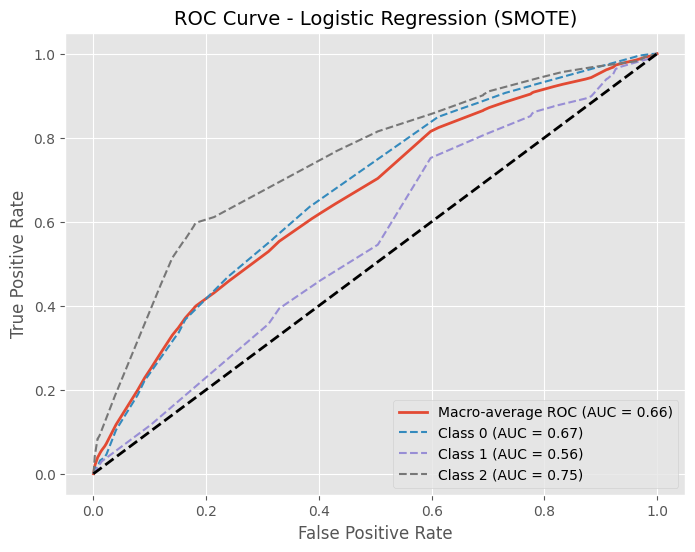

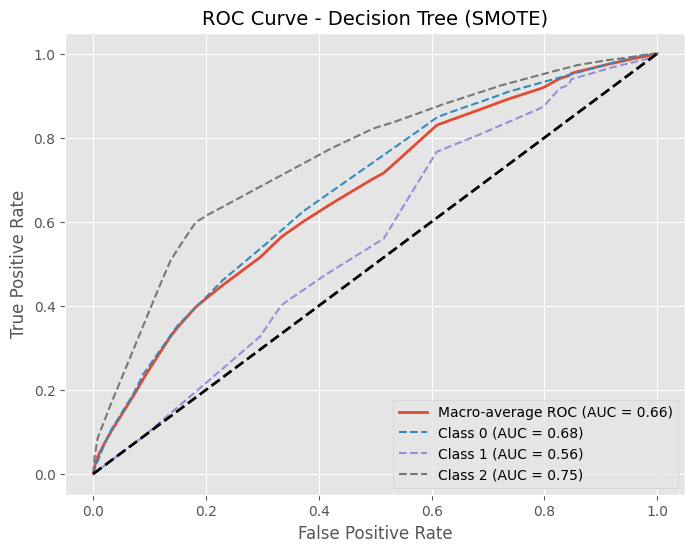

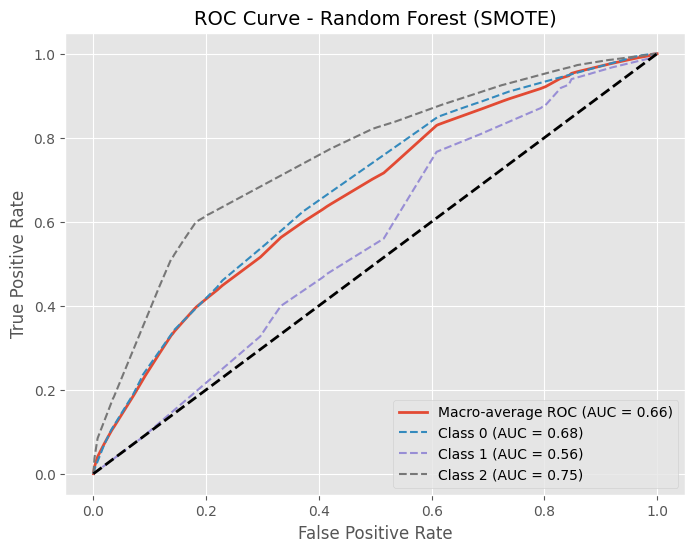

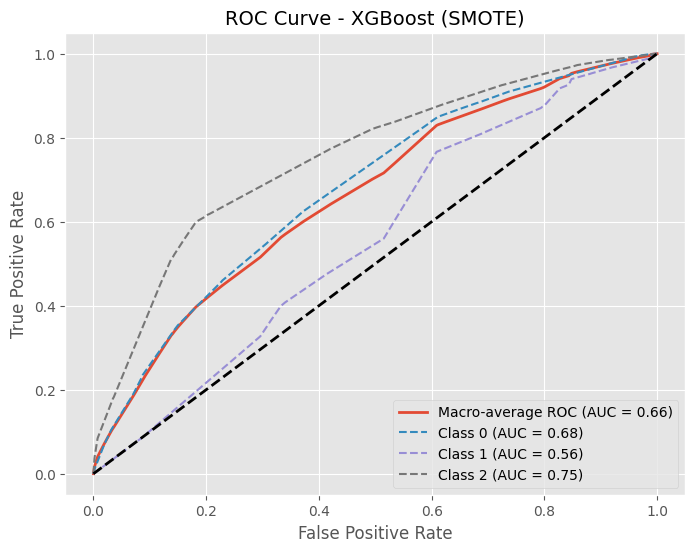

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize y3_test for multi-class ROC
y3_test_bin = label_binarize(y3_test, classes=[0, 1, 2])
n_classes = y3_test_bin.shape[1]

# Define model names and TEST predicted probabilities
model_probs_rq3 = {
    "Logistic Regression (SMOTE)": y3_test_proba_lr,
    "Decision Tree (SMOTE)": y3_test_proba_dt,
    "Random Forest (SMOTE)": y3_test_proba_rf,
    "XGBoost (SMOTE)": y3_test_proba_xgb
}

# Plot ROC curves for each model
for model_name, probs in model_probs_rq3.items():
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y3_test_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(all_fpr, mean_tpr, label=f"Macro-average ROC (AUC = {macro_auc:.2f})", linewidth=2)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], linestyle='--', label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.title(f"ROC Curve - {model_name}", fontsize=14)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

**Validating on best model**

As all models have similar peformance. Checking which model performs best on validation set

In [51]:
def evaluate_validation_only(name, y_true, y_pred, y_proba):
    print(f"==== {name} - Validation Only ====")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro', zero_division=0))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_true, y_pred, average='macro'))
    print("Cohen’s Kappa:", cohen_kappa_score(y_true, y_pred))
    print("AUC (OvR, weighted):", roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted'))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("=" * 60)

# Decision Tree
y3_val_pred_dt = dt3.predict(X3_val)
y3_val_proba_dt = dt3.predict_proba(X3_val)
evaluate_validation_only("Decision Tree", y3_val, y3_val_pred_dt, y3_val_proba_dt)

# Random Forest
y3_val_pred_rf = rf3.predict(X3_val)
y3_val_proba_rf = rf3.predict_proba(X3_val)
evaluate_validation_only("Random Forest", y3_val, y3_val_pred_rf, y3_val_proba_rf)

# XGBoost
y3_val_pred_xgb = xgb3.predict(X3_val)
y3_val_proba_xgb = xgb3.predict_proba(X3_val)
evaluate_validation_only("XGBoost", y3_val, y3_val_pred_xgb, y3_val_proba_xgb)

==== Decision Tree - Validation Only ====
Accuracy: 0.5774
Precision (macro): 0.3740992322670685
Recall (macro): 0.49080173345178535
F1 Score: 0.35422911322515716
Cohen’s Kappa: 0.097024201676148
AUC (OvR, weighted): 0.6585011047059132
Confusion Matrix:
 [[26505  9114  6445]
 [ 2813  1620  2262]
 [  278   218   745]]
==== Random Forest - Validation Only ====
Accuracy: 0.5774
Precision (macro): 0.3740992322670685
Recall (macro): 0.49080173345178535
F1 Score: 0.35422911322515716
Cohen’s Kappa: 0.097024201676148
AUC (OvR, weighted): 0.6582793642420219
Confusion Matrix:
 [[26505  9114  6445]
 [ 2813  1620  2262]
 [  278   218   745]]
==== XGBoost - Validation Only ====
Accuracy: 0.5774
Precision (macro): 0.3740992322670685
Recall (macro): 0.49080173345178535
F1 Score: 0.35422911322515716
Cohen’s Kappa: 0.097024201676148
AUC (OvR, weighted): 0.6585003889801068
Confusion Matrix:
 [[26505  9114  6445]
 [ 2813  1620  2262]
 [  278   218   745]]


## Research Question - 04:

In [52]:
# Copy original dataframe
df_rq4 = df.copy()

# Select relevant location/roadway features
location_features = [
    'Texas Triangle',
    'At Intersection Flag',
    'Construction Zone Flag',
    'Rural Urban Type'
]

# Include all related one-hot columns
road_class_cols = [col for col in df_rq4.columns if col.startswith('Road Class_')]
road_type_cols = [col for col in df_rq4.columns if col.startswith('Roadway Type_')]
relation_cols = [col for col in df_rq4.columns if col.startswith('Roadway Relation_')]

features_rq4 = location_features + road_class_cols + road_type_cols + relation_cols

# Full feature and target set
X4_full = df_rq4[features_rq4].copy()
y4_full = df_rq4['Crash Severity']

# Create validation set (last 50,000 rows)
X4_val = X4_full.iloc[-50000:].copy()
y4_val = y4_full.iloc[-50000:].copy()

# Use remaining for training/testing
X4 = X4_full.iloc[:-50000].copy()
y4 = y4_full.iloc[:-50000:].copy()

# Convert boolean columns to int safely
bool_cols_rq4 = X4.select_dtypes(include='bool').columns
X4[bool_cols_rq4] = X4[bool_cols_rq4].astype(int)
X4_val[bool_cols_rq4] = X4_val[bool_cols_rq4].astype(int)

# Scale numeric columns
from sklearn.preprocessing import MinMaxScaler
num_cols_rq4 = X4.select_dtypes(include=['int64', 'float64']).columns

scaler4 = MinMaxScaler()
X4[num_cols_rq4] = scaler4.fit_transform(X4[num_cols_rq4])
X4_val[num_cols_rq4] = scaler4.transform(X4_val[num_cols_rq4])

# Split into training and test sets
from sklearn.model_selection import train_test_split
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.3, random_state=42)

**Logistic Regression**

In [53]:
from sklearn.linear_model import LogisticRegression

lr4 = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
lr4.fit(X4_train, y4_train)

y4_pred_lr = lr4.predict(X4_test)
y4_proba_lr = lr4.predict_proba(X4_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [54]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    cohen_kappa_score, roc_auc_score, confusion_matrix
)

print("Logistic Regression:")
print("Accuracy:", accuracy_score(y4_test, y4_pred_lr))
print("Precision (macro):", precision_score(y4_test, y4_pred_lr, average='macro'))
print("Recall (macro):", recall_score(y4_test, y4_pred_lr, average='macro'))
print("F1 Score:", f1_score(y4_test, y4_pred_lr, average='macro'))
print("Cohen’s Kappa:", cohen_kappa_score(y4_test, y4_pred_lr))
print("AUC (OvR, weighted):", roc_auc_score(y4_test, y4_proba_lr, multi_class='ovr', average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y4_test, y4_pred_lr))

Logistic Regression:
Accuracy: 0.8354930848735104
Precision (macro): 0.27849769495783677
Recall (macro): 0.3333333333333333
F1 Score: 0.3034581794428596
Cohen’s Kappa: 0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC (OvR, weighted): 0.5801964821518735
Confusion Matrix:
 [[433204      0      0]
 [ 69422      0      0]
 [ 15875      0      0]]


**Decision Tree Classifier**

In [55]:
from sklearn.tree import DecisionTreeClassifier

dt4 = DecisionTreeClassifier(random_state=42)
dt4.fit(X4_train, y4_train)

y4_pred_dt = dt4.predict(X4_test)
y4_proba_dt = dt4.predict_proba(X4_test)

In [56]:
print("Decision Tree:")
print("Accuracy:", accuracy_score(y4_test, y4_pred_dt))
print("Precision (macro):", precision_score(y4_test, y4_pred_dt, average='macro'))
print("Recall (macro):", recall_score(y4_test, y4_pred_dt, average='macro'))
print("F1 Score:", f1_score(y4_test, y4_pred_dt, average='macro'))
print("Cohen’s Kappa:", cohen_kappa_score(y4_test, y4_pred_dt))
print("AUC (OvR, weighted):", roc_auc_score(y4_test, y4_proba_dt, multi_class='ovr', average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y4_test, y4_pred_dt))

Decision Tree:
Accuracy: 0.8355123712393997
Precision (macro): 0.7684059388304355
Recall (macro): 0.33349861679222353
F1 Score: 0.303805098335847
Cohen’s Kappa: 0.0003547292345190689
AUC (OvR, weighted): 0.5862684602833365
Confusion Matrix:
 [[433195      8      1]
 [ 69408     14      0]
 [ 15870      0      5]]


**Random Forest Classifier**

In [57]:
from sklearn.ensemble import RandomForestClassifier

rf4 = RandomForestClassifier(n_estimators=100, random_state=42)
rf4.fit(X4_train, y4_train)

y4_pred_rf = rf4.predict(X4_test)
y4_proba_rf = rf4.predict_proba(X4_test)

In [58]:
print("Random Forest:")
print("Accuracy:", accuracy_score(y4_test, y4_pred_rf))
print("Precision (macro):", precision_score(y4_test, y4_pred_rf, average='macro'))
print("Recall (macro):", recall_score(y4_test, y4_pred_rf, average='macro'))
print("F1 Score:", f1_score(y4_test, y4_pred_rf, average='macro'))
print("Cohen’s Kappa:", cohen_kappa_score(y4_test, y4_pred_rf))
print("AUC (OvR, weighted):", roc_auc_score(y4_test, y4_proba_rf, multi_class='ovr', average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y4_test, y4_pred_rf))

Random Forest:
Accuracy: 0.8354950135100994
Precision (macro): 0.7044333231678808
Recall (macro): 0.3334997558312873
F1 Score: 0.3038210259289604
Cohen’s Kappa: 0.0003643271427413719
AUC (OvR, weighted): 0.586299377478867
Confusion Matrix:
 [[433184     19      1]
 [ 69406     16      0]
 [ 15869      1      5]]


**XGBoost Classifier**

In [59]:
from xgboost import XGBClassifier

xgb4 = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb4.fit(X4_train, y4_train)

y4_pred_xgb = xgb4.predict(X4_test)
y4_proba_xgb = xgb4.predict_proba(X4_test)

In [60]:
print("XGBoost Classifier:")
print("Accuracy:", accuracy_score(y4_test, y4_pred_xgb))
print("Precision (macro):", precision_score(y4_test, y4_pred_xgb, average='macro'))
print("Recall (macro):", recall_score(y4_test, y4_pred_xgb, average='macro'))
print("F1 Score:", f1_score(y4_test, y4_pred_xgb, average='macro'))
print("Cohen’s Kappa:", cohen_kappa_score(y4_test, y4_pred_xgb))
print("AUC (OvR, weighted):", roc_auc_score(y4_test, y4_proba_xgb, multi_class='ovr', average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y4_test, y4_pred_xgb))

XGBoost Classifier:
Accuracy: 0.8355104426028108
Precision (macro): 0.7572942905526604
Recall (macro): 0.3334776194168954
F1 Score: 0.30376281115605175
Cohen’s Kappa: 0.0003335775074860825
AUC (OvR, weighted): 0.5862669291305762
Confusion Matrix:
 [[433195      8      1]
 [ 69408     14      0]
 [ 15871      0      4]]


**RQ4: Model Tuning**

In [61]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X4_train_res, y4_train_res = smote.fit_resample(X4_train, y4_train)

# Check class distribution
from collections import Counter
print("Resampled class distribution:", Counter(y4_train_res))

Resampled class distribution: Counter({0: 1010757, 1: 1010757, 2: 1010757})


In [62]:
from sklearn.linear_model import LogisticRegression

lr4 = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
lr4.fit(X4_train_res, y4_train_res)

y4_pred_lr = lr4.predict(X4_test)
y4_proba_lr = lr4.predict_proba(X4_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [63]:
from sklearn.tree import DecisionTreeClassifier

dt4 = DecisionTreeClassifier(random_state=42)
dt4.fit(X4_train_res, y4_train_res)

y4_pred_dt = dt4.predict(X4_test)
y4_proba_dt = dt4.predict_proba(X4_test)

In [64]:
from sklearn.ensemble import RandomForestClassifier

rf4 = RandomForestClassifier(n_estimators=100, random_state=42)
rf4.fit(X4_train_res, y4_train_res)

y4_pred_rf = rf4.predict(X4_test)
y4_proba_rf = rf4.predict_proba(X4_test)


In [65]:
from xgboost import XGBClassifier

xgb4 = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb4.fit(X4_train_res, y4_train_res)

y4_pred_xgb = xgb4.predict(X4_test)
y4_proba_xgb = xgb4.predict_proba(X4_test)

In [66]:
# Logistic Regression
y4_train_pred_lr = lr4.predict(X4_train_res)
y4_train_proba_lr = lr4.predict_proba(X4_train_res)
y4_test_pred_lr = lr4.predict(X4_test)
y4_test_proba_lr = lr4.predict_proba(X4_test)

# Decision Tree
y4_train_pred_dt = dt4.predict(X4_train_res)
y4_train_proba_dt = dt4.predict_proba(X4_train_res)
y4_test_pred_dt = dt4.predict(X4_test)
y4_test_proba_dt = dt4.predict_proba(X4_test)

# Random Forest
y4_train_pred_rf = rf4.predict(X4_train_res)
y4_train_proba_rf = rf4.predict_proba(X4_train_res)
y4_test_pred_rf = rf4.predict(X4_test)
y4_test_proba_rf = rf4.predict_proba(X4_test)

# XGBoost
y4_train_pred_xgb = xgb4.predict(X4_train_res)
y4_train_proba_xgb = xgb4.predict_proba(X4_train_res)
y4_test_pred_xgb = xgb4.predict(X4_test)
y4_test_proba_xgb = xgb4.predict_proba(X4_test)

In [67]:
def evaluate_model(name, y_true_train, y_pred_train, y_proba_train, y_true_test, y_pred_test, y_proba_test):
    print(f"==== {name} ====")
    print("--- Training Metrics ---")
    print("Accuracy:", accuracy_score(y_true_train, y_pred_train))
    print("Precision (macro):", precision_score(y_true_train, y_pred_train, average='macro', zero_division=0))
    print("Recall (macro):", recall_score(y_true_train, y_pred_train, average='macro'))
    print("F1 Score:", f1_score(y_true_train, y_pred_train, average='macro'))
    print("Cohen’s Kappa:", cohen_kappa_score(y_true_train, y_pred_train))
    print("AUC (OvR, weighted):", roc_auc_score(y_true_train, y_proba_train, multi_class='ovr', average='weighted'))
    print()
    print("--- Testing Metrics ---")
    print("Accuracy:", accuracy_score(y_true_test, y_pred_test))
    print("Precision (macro):", precision_score(y_true_test, y_pred_test, average='macro', zero_division=0))
    print("Recall (macro):", recall_score(y_true_test, y_pred_test, average='macro'))
    print("F1 Score:", f1_score(y_true_test, y_pred_test, average='macro'))
    print("Cohen’s Kappa:", cohen_kappa_score(y_true_test, y_pred_test))
    print("AUC (OvR, weighted):", roc_auc_score(y_true_test, y_proba_test, multi_class='ovr', average='weighted'))
    print("Confusion Matrix:\n", confusion_matrix(y_true_test, y_pred_test))
    print("="*60)

In [68]:
# Logistic Regression
evaluate_model("Logistic Regression", y4_train_res, y4_train_pred_lr, y4_train_proba_lr, y4_test, y4_test_pred_lr, y4_test_proba_lr)
# Decision Tree
evaluate_model("Decision Tree", y4_train_res, y4_train_pred_dt, y4_train_proba_dt, y4_test, y4_test_pred_dt, y4_test_proba_dt)
# Random Forest
evaluate_model("Random Forest", y4_train_res, y4_train_pred_rf, y4_train_proba_rf, y4_test, y4_test_pred_rf, y4_test_proba_rf)
# XGBoost
evaluate_model("XGBoost", y4_train_res, y4_train_pred_xgb, y4_train_proba_xgb, y4_test, y4_test_pred_xgb, y4_test_proba_xgb)

==== Logistic Regression ====
--- Training Metrics ---
Accuracy: 0.41805630169598956
Precision (macro): 0.4346598254808865
Recall (macro): 0.41805630169598956
F1 Score: 0.40970506368420706
Cohen’s Kappa: 0.12708445254398426
AUC (OvR, weighted): 0.5909282021905569

--- Testing Metrics ---
Accuracy: 0.5484078140640037
Precision (macro): 0.3672561780012527
Recall (macro): 0.4192688767065249
F1 Score: 0.3469652235243987
Cohen’s Kappa: 0.06745885908359905
AUC (OvR, weighted): 0.576222688034561
Confusion Matrix:
 [[253192 125321  54691]
 [ 32441  26537  10444]
 [  6831   4423   4621]]
==== Decision Tree ====
--- Training Metrics ---
Accuracy: 0.4240422442453198
Precision (macro): 0.4377904746290415
Recall (macro): 0.4240422442453198
F1 Score: 0.4193982886257151
Cohen’s Kappa: 0.13606336636797967
AUC (OvR, weighted): 0.6020264530355993

--- Testing Metrics ---
Accuracy: 0.5248958054082827
Precision (macro): 0.3667451746517681
Recall (macro): 0.42394243750478294
F1 Score: 0.33983239161356266
C

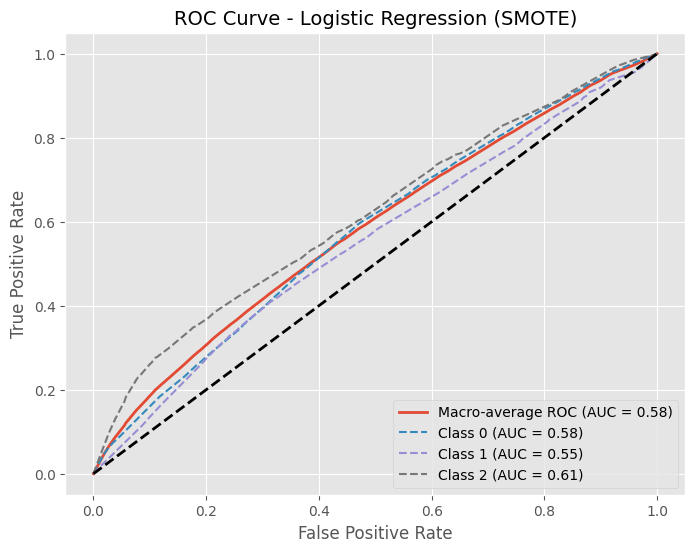

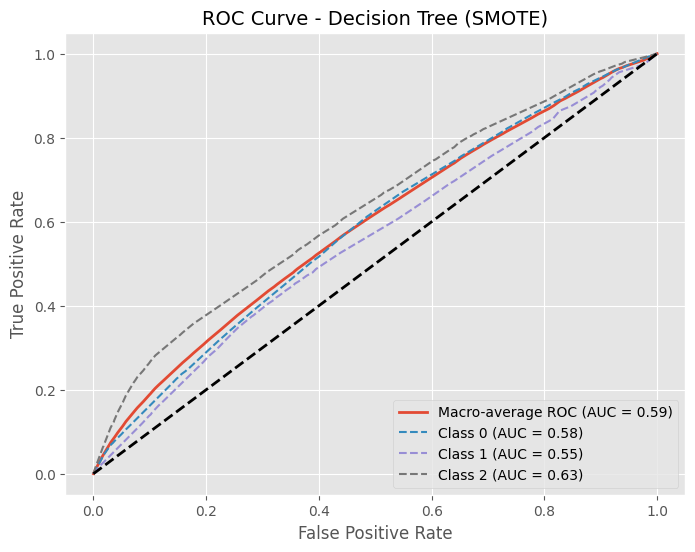

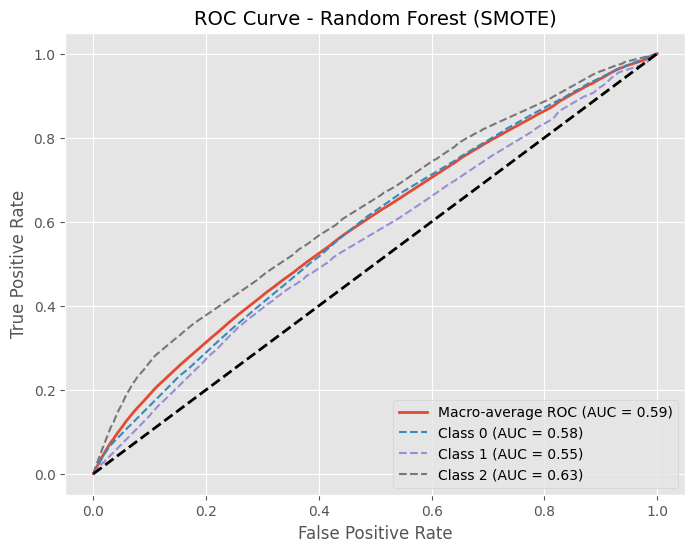

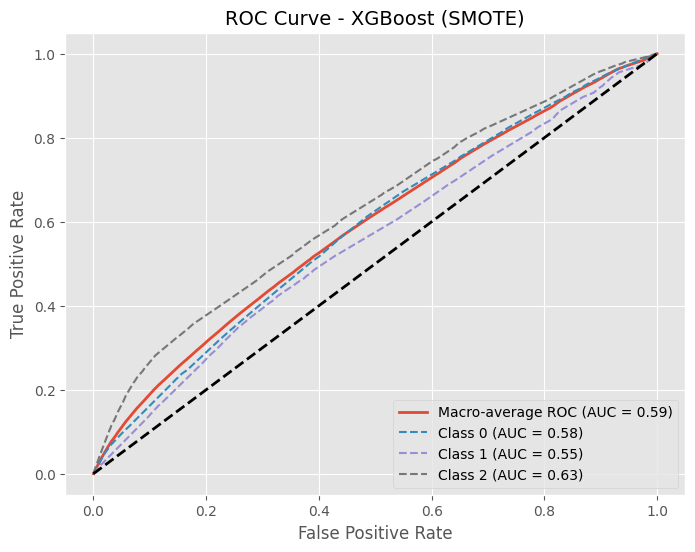

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the output labels for ROC computation
y4_test_bin = label_binarize(y4_test, classes=[0, 1, 2])
n_classes = y4_test_bin.shape[1]

# Define model names and TEST predicted probabilities
model_probs = {
    "Logistic Regression (SMOTE)": y4_test_proba_lr,
    "Decision Tree (SMOTE)": y4_test_proba_dt,
    "Random Forest (SMOTE)": y4_test_proba_rf,
    "XGBoost (SMOTE)": y4_test_proba_xgb
}

# Plot ROC for each model
for model_name, probs in model_probs.items():
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y4_test_bin[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(all_fpr, mean_tpr, label=f"Macro-average ROC (AUC = {macro_auc:.2f})", linewidth=2)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], linestyle='--', label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.title(f"ROC Curve - {model_name}", fontsize=14)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

**Validating using XgBoost Model:**

In [70]:
y4_val_pred_xgb = xgb4.predict(X4_val)
y4_val_proba_xgb = xgb4.predict_proba(X4_val)

evaluate_validation_only("XGBoost - RQ4", y4_val, y4_val_pred_xgb, y4_val_proba_xgb)

==== XGBoost - RQ4 - Validation Only ====
Accuracy: 0.53596
Precision (macro): 0.36598343787856785
Recall (macro): 0.4211189506618398
F1 Score: 0.3384985021115881
Cohen’s Kappa: 0.06761351043792219
AUC (OvR, weighted): 0.5856661884634243
Confusion Matrix:
 [[23693 12904  5467]
 [ 2964  2745   986]
 [  434   447   360]]


**Feature Importances**

In [71]:
import pandas as pd

feature_importance_rq1 = pd.DataFrame({
    'Feature': X1.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances - RQ1")
print(feature_importance_rq1)

Feature Importances - RQ1
                                  Feature  Importance
9                  Person Airbag Deployed    0.127112
55    Vehicle Damage Area_Motorcycle Only    0.072027
6      Vehicle Damage Rating 1 - Severity    0.049022
73       Event_MOTOR VEHICLE IN TRANSPORT    0.039037
85             RoadwayRelation_ON ROADWAY    0.031377
..                                    ...         ...
42            License State_AR - ARKANSAS    0.001919
98                  BAC_Above Legal Limit    0.000908
21                         Elderly Driver    0.000000
20                           Youth Driver    0.000000
78  Manner of Collision_ONE MOTOR VEHICLE    0.000000

[102 rows x 2 columns]


In [72]:
feature_importance_rq2 = pd.DataFrame({
    'Feature': X2.columns,
    'Importance': xgb2.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances - RQ2")
print(feature_importance_rq2)


Feature Importances - RQ2
                                  Feature  Importance
7                Vehicle Hit and Run Flag    0.094963
91                             Time_Night    0.045991
19                      Driver Impairment    0.032513
55       Vehicle Damage Area_Front Impact    0.027101
86             RoadwayRelation_ON ROADWAY    0.024471
..                                    ...         ...
99                  BAC_Above Legal Limit    0.001506
34                 Road Class_OTHER ROADS    0.000744
22                         Elderly Driver    0.000000
21                           Youth Driver    0.000000
79  Manner of Collision_ONE MOTOR VEHICLE    0.000000

[103 rows x 2 columns]


In [73]:
feature_importance_rq3 = pd.DataFrame({
    'Feature': X3.columns,
    'Importance': xgb3.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances - RQ3")
print(feature_importance_rq3)


Feature Importances - RQ3
                                   Feature  Importance
9              Vehicle Damage Area_Unknown    0.393867
5      Vehicle Damage Area_Motorcycle Only    0.328886
0       Vehicle Damage Rating 1 - Severity    0.131874
6  Vehicle Damage Area_Rollover/Top Impact    0.037507
4         Vehicle Damage Area_Front Impact    0.030504
3          Vehicle Damage Area_Back Impact    0.024129
1                 Vehicle Hit and Run Flag    0.022324
2       Vehicle Damage Area_Angular Impact    0.017308
7        Vehicle Damage Area_Severe Damage    0.007486
8          Vehicle Damage Area_Side Impact    0.006114


In [75]:
feature_importance_rq4 = pd.DataFrame({
    'Feature': X4.columns,
    'Importance': xgb4.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances - RQ4")
print(feature_importance_rq4)


Feature Importances - RQ4
                                    Feature  Importance
8                 Road Class_NON TRAFFICWAY    0.329334
12               Roadway Type_2 LANE, 2 WAY    0.318457
15             Roadway Type_OTHER ROAD TYPE    0.080304
3                          Rural Urban Type    0.056362
4                    Road Class_CITY STREET    0.048814
1                      At Intersection Flag    0.035570
11           Road Class_US & STATE HIGHWAYS    0.031087
5                    Road Class_COUNTY ROAD    0.026806
7                     Road Class_INTERSTATE    0.015866
13    Roadway Type_4 OR MORE LANES, DIVIDED    0.012257
0                            Texas Triangle    0.011330
6                 Road Class_FARM TO MARKET    0.008182
2                    Construction Zone Flag    0.007325
14  Roadway Type_4 OR MORE LANES, UNDIVIDED    0.006945
10                       Road Class_TOLLWAY    0.006444
9                    Road Class_OTHER ROADS    0.004918


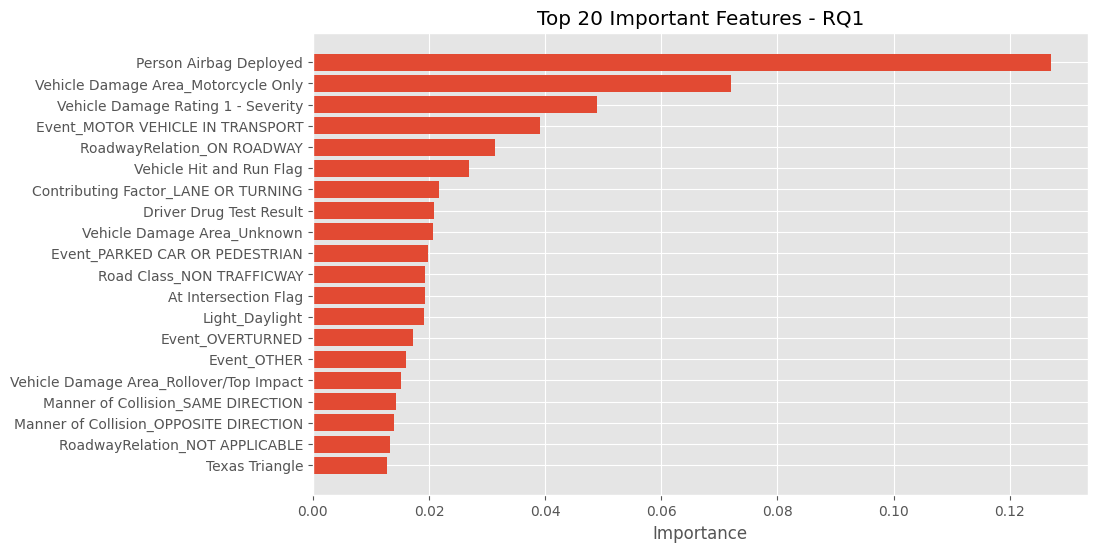

In [76]:
import matplotlib.pyplot as plt

top_features = feature_importance_rq1.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 Important Features - RQ1')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

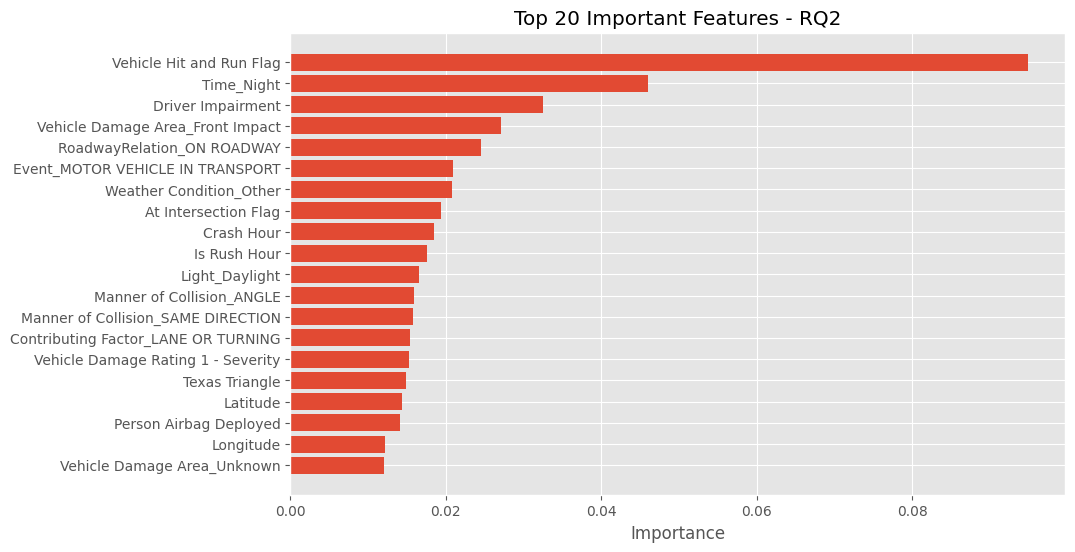

In [77]:
import matplotlib.pyplot as plt

top_features = feature_importance_rq2.head(20)  # or rq2/rq3/rq4
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 Important Features - RQ2')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


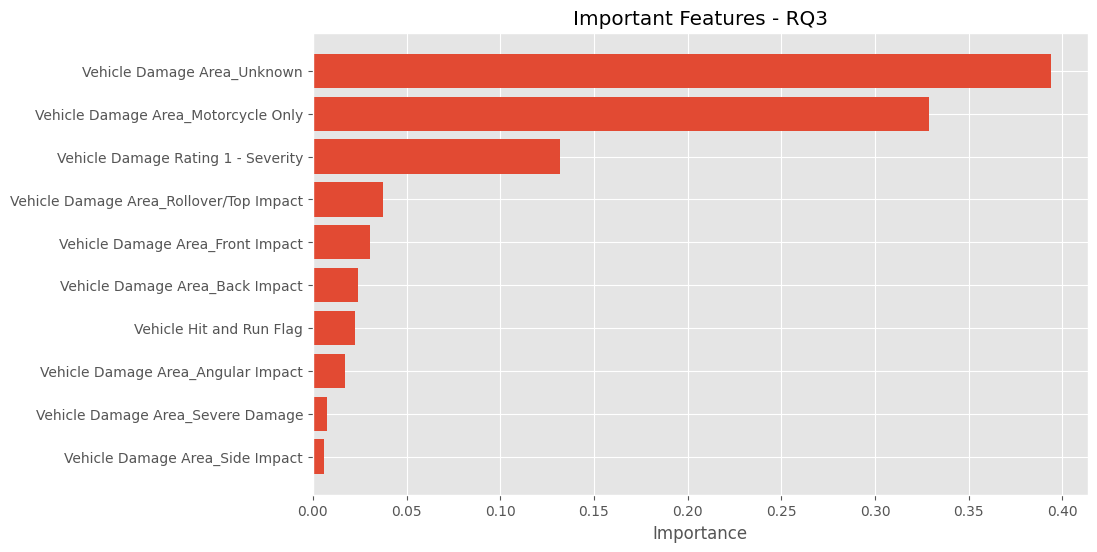

In [78]:
import matplotlib.pyplot as plt

top_features = feature_importance_rq3
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title('Important Features - RQ3')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()


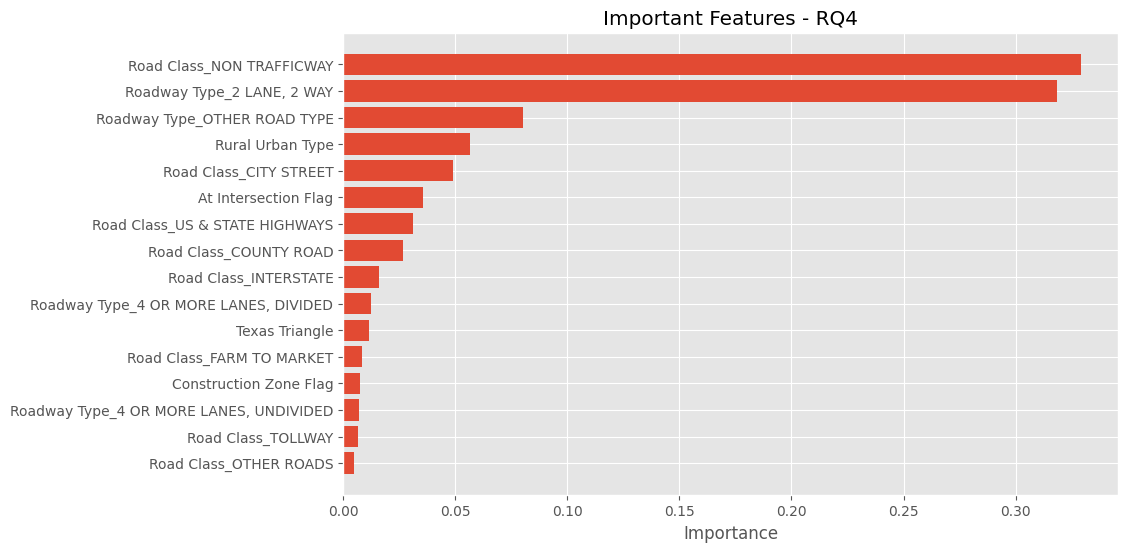

In [79]:
top_features = feature_importance_rq4
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title('Important Features - RQ4')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()